In [3]:
import re
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

from wordcloud import WordCloud

# Download NLTK data
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tylernardone/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tylernardone/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tylernardone/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tylernardone/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# Read in raw data
BASE_DIR = Path().resolve().parent
DATA_DIR = BASE_DIR / "data"

df = pd.read_csv(DATA_DIR / "intermediate" / "25072024_reviews_openrefine.csv")

In [24]:
drop_words = [
    "mouthfeel",
    "aroma",
    "flavor",
    "like",
    "finish",
    "hint",
    "note",
    "cup",
    "consolidates",
    "keurig",
    "single",
    "device",
    "suggestion",
    "acidy",
    "ken",
    "deeply",
    "ounce",
    "part",
    "profile",
    "structure",
]


def preprocess_text_with_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    # Remove non-alphanumeric characters
    text = re.sub(r"\W", " ", text)
    # Tokenize and convert to lowercase
    tokens = word_tokenize(text.lower())
    # POS tagging
    pos_tags = pos_tag(tokens)

    # Remove adverbs, verbs, and stopwords from pos_tags
    pos_tags_filtered = [
        (word, pos)
        for word, pos in pos_tags
        if not (pos.startswith("V") or pos.startswith("R"))
        and word not in ENGLISH_STOP_WORDS
    ]

    # Lemmatize words based on POS tags
    lemmatized_words = [
        lemmatizer.lemmatize(
            word, get_wordnet_tag(pos) or "n"
        )  # Default to noun if no tag
        for word, pos in pos_tags_filtered
    ]

    filtered_lemmatized_words = [
        word for word in lemmatized_words if word not in drop_words
    ]
    return " ".join(filtered_lemmatized_words)


def get_wordnet_tag(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

In [25]:
df["cleaned_assessment"] = df["blind_assessment"].apply(
    preprocess_text_with_lemmatization
)

In [26]:
vectorizer = TfidfVectorizer(max_features=200)
tfidf_matrix = vectorizer.fit_transform(df["cleaned_assessment"])
keywords = vectorizer.get_feature_names_out()

In [27]:
print(keywords)

['acidity' 'almond' 'apple' 'apricot' 'aromatic' 'aromatics' 'astringency'
 'astringent' 'baker' 'balance' 'balanced' 'banana' 'bergamot' 'berry'
 'big' 'bit' 'bitter' 'bittersweet' 'black' 'blackberry' 'blend' 'blood'
 'blossom' 'blueberry' 'body' 'brandy' 'brewing' 'bright' 'brisk'
 'brittle' 'brown' 'buoyant' 'butter' 'buttery' 'cacao' 'capsule'
 'caramel' 'carry' 'cashew' 'cedar' 'center' 'character' 'cherry'
 'chocolate' 'chocolaty' 'cinnamon' 'citrus' 'citrusy' 'clean' 'cocoa'
 'coffee' 'complex' 'complexity' 'complexly' 'complication' 'continued'
 'creamy' 'crisp' 'crisply' 'currant' 'cut' 'dark' 'date' 'deep'
 'delicate' 'distinct' 'dried' 'dry' 'earth' 'earthy' 'edge' 'elegant'
 'espresso' 'ferment' 'fine' 'fir' 'floral' 'florals' 'flower'
 'frankincense' 'freesia' 'fresh' 'fruit' 'fruity' 'fudge' 'gardenia'
 'gentle' 'ginger' 'grape' 'grapefruit' 'green' 'guava' 'hazelnut' 'heavy'
 'herb' 'high' 'honey' 'honeysuckle' 'hop' 'intense' 'jasmine' 'juicy'
 'lavender' 'lead' 'lean'

In [28]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=keywords)

In [29]:
df = pd.concat([df, tfidf_df], axis=1)

In [30]:
tfidf_df.describe()

acidity       almond        apple      apricot     aromatic  \
count  7563.000000  7563.000000  7563.000000  7563.000000  7563.000000   
mean      0.068932     0.028600     0.011990     0.022845     0.023034   
std       0.052046     0.089050     0.067357     0.086059     0.076081   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.084617     0.000000     0.000000     0.000000     0.000000   
75%       0.104523     0.000000     0.000000     0.000000     0.000000   
max       0.604512     0.634333     0.712253     0.680384     0.610866   

         aromatics  astringency   astringent        baker      balance  ...  \
count  7563.000000  7563.000000  7563.000000  7563.000000  7563.000000  ...   
mean      0.007750     0.009997     0.010198     0.012353     0.006823  ...   
std       0.054233     0.056473     0.059832     0.064893     0.050439  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
max       0.764447     0.607307     0.716592     0.589502     0.811620  ...   

           velvety      verbena      vibrant       violet      viscous  \
count  7563.000000  7563.000000  7563.000000  7563.000000  7563.000000   
mean      0.016625     0.010838     0.014377     0.006753     0.009245   
std       0.062151     0.064407     0.060189     0.051905     0.050884   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.423735     0.676565     0.586686     0.665793     0.427053   

            walnut         wine     wisteria         wood         zest  
count  7563.000000  7563.000000  7563.000000  7563.000000  7563.000000  
mean      0.010771     0.011781     0.007710     0.022702     0.033873  
std       0.067637     0.067643     0.056154     0.083208     0.087994  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       0.836265     0.841099     0.723518     0.705773     0.545502  

[8 rows x 200 columns]

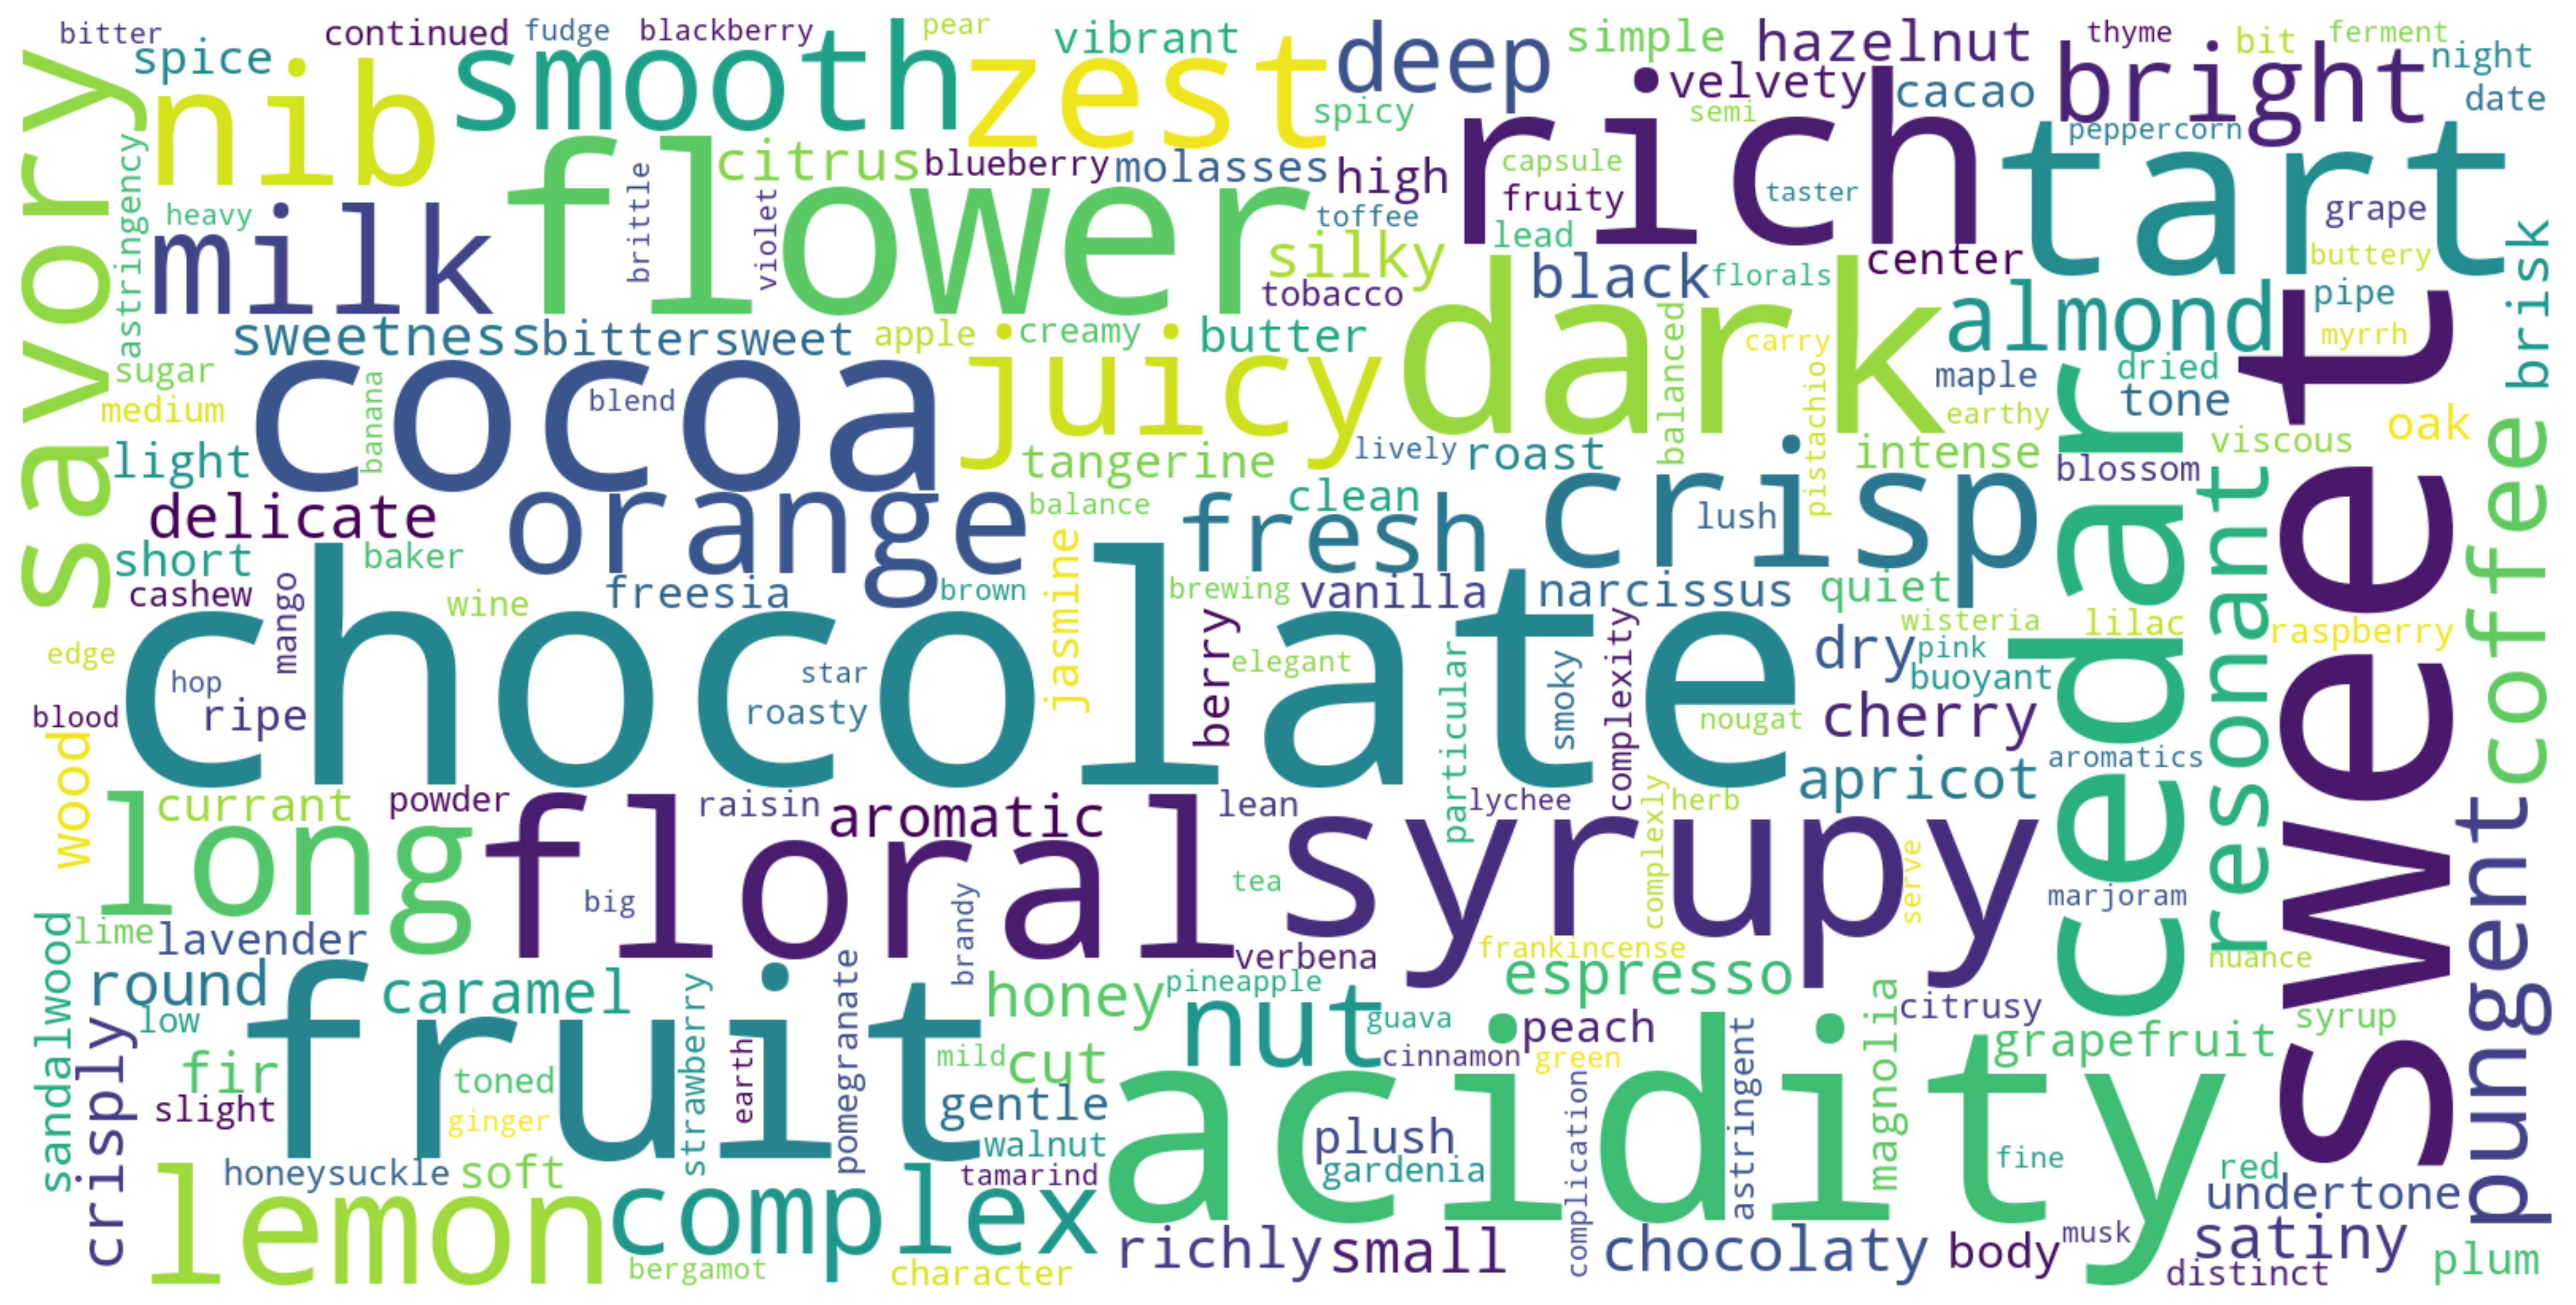

In [31]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Sum TF-IDF values for each word
tfidf_scores = tfidf_matrix.sum(axis=0).A1
word_scores = dict(zip(feature_names, tfidf_scores))

# Create and display the word cloud
wordcloud = WordCloud(
    width=1600, height=800, background_color="white", max_font_size=200
)
wordcloud.generate_from_frequencies(word_scores)

# Plot the word cloud
plt.figure(figsize=(20, 10), dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()